<a href="https://colab.research.google.com/github/owilli38/DSBA-6211/blob/main/TextMining_owilli38.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk
import spacy
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
dfOW = pd.read_csv('/content/book_ratings.csv')

In [ ]:

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.stem import PorterStemmer

def preprocess_text(text):

    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)


    text = text.lower()


    tokens = nltk.word_tokenize(text)


    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]


    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in tokens]

    return stems

dfOW['processed_summary'] = dfOW['review/summary'].apply(preprocess_text)
dfOW['processed_text'] = dfOW['review/text'].apply(preprocess_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


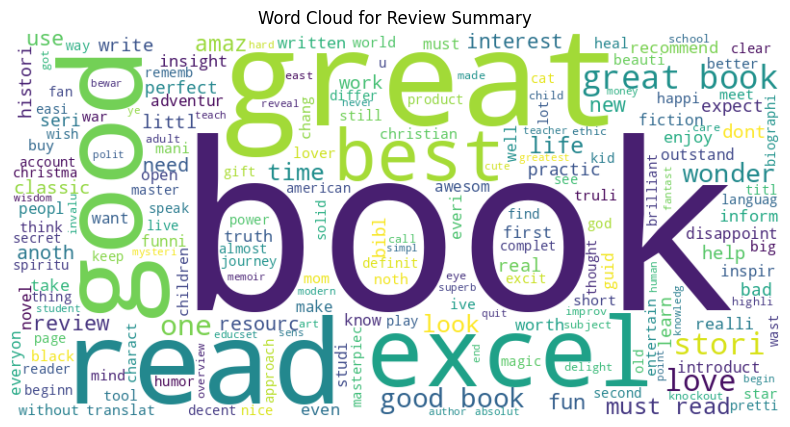

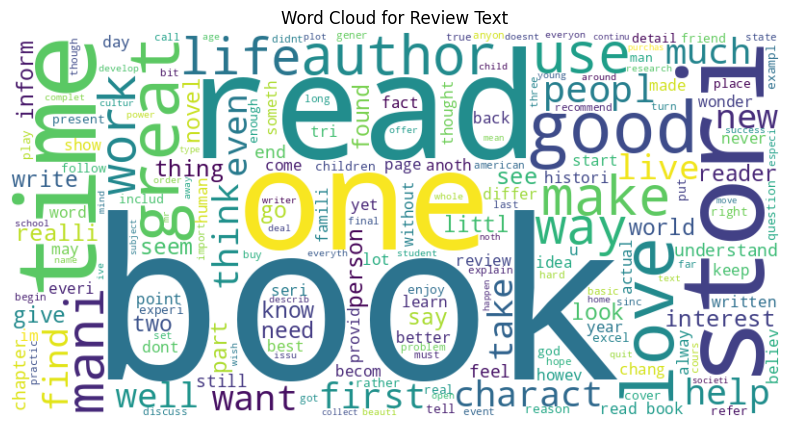

In [ ]:
# Create a word cloud for "review/summary"
summary_text = ' '.join([' '.join(tokens) for tokens in dfOW['processed_summary']])
wordcloud_summary = WordCloud(width=800, height=400, background_color='white').generate(summary_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Review Summary')
plt.show()

# Create a word cloud for "review/text"
text_text = ' '.join([' '.join(tokens) for tokens in dfOW['processed_text']])
wordcloud_text = WordCloud(width=800, height=400, background_color='white').generate(text_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_text, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Review Text')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # Correct import
from sklearn.metrics.pairwise import cosine_similarity

dfOW['summary_string'] = dfOW['processed_summary'].apply(' '.join)
dfOW['text_string'] = dfOW['processed_text'].apply(' '.join)

# 1. Create TF-IDF vectors for 'review/summary'
summary_vectorizer = TfidfVectorizer() # Using the correct class name
tfidf_summary = summary_vectorizer.fit_transform(dfOW['review/summary'])
summary_similarity = cosine_similarity(tfidf_summary)

# 2. Create TF-IDF vectors for 'review/text'
text_vectorizer = TfidfVectorizer() # Using the correct class name
tfidf_text = text_vectorizer.fit_transform(dfOW['review/text'])
text_similarity = cosine_similarity(tfidf_text)

# 3. Display similarity tables for the first 5 documents
print("Similarity Matrix for Review Summary (First 5 Documents):")
print(summary_similarity[:5, :5])

print("\nSimilarity Matrix for Review Text (First 5 Documents):")
print(text_similarity[:5, :5])

Similarity Matrix for Review Summary (First 5 Documents):
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

Similarity Matrix for Review Text (First 5 Documents):
[[1.         0.04684839 0.03120973 0.02039019 0.04317329]
 [0.04684839 1.         0.15705807 0.11386684 0.19126708]
 [0.03120973 0.15705807 1.         0.08635174 0.12898293]
 [0.02039019 0.11386684 0.08635174 1.         0.11871905]
 [0.04317329 0.19126708 0.12898293 0.11871905 1.        ]]


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(dfOW['text_string'])

lda = LatentDirichletAllocation(n_components=6, random_state=42)
lda.fit(dtm)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 1:
book peopl author use help inform make mani think point
Topic 2:
book like mani love life read work use stori help
Topic 3:
book like read stori peopl time life make realli failur
Topic 4:
book read love time like great good use recommend author
Topic 5:
book read stori novel way charact mani good time great
Topic 6:
book read stori charact life great reader work mani understand


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Model 1: Using 5 SVD components
svdOW = TruncatedSVD(n_components=5, random_state=42)
svdOW_features = svd.fit_transform(tfidf_text)

X = pd.DataFrame(svdOW_features)
X = pd.concat([dfOW[['review/helpfulness', 'Price']], pd.DataFrame(X)],axis=1)
X.columns = X.columns.astype(str)
y = dfOW['review/score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelOW_1 = DecisionTreeClassifier(random_state=42)
modelOW_1.fit(X_train, y_train)
y_pred_1 = modelOW_1.predict(X_test)
conf_matrix_1 = confusion_matrix(y_test, y_pred_1)
print("Confusion Matrix for Model-1:")
print(conf_matrix_1)

# Model 2: Using 8 SVD components
svdOW_2 = TruncatedSVD(n_components=8, random_state=42)
svdOW_features_2 = svdOW_2.fit_transform(tfidf_text)

X_2 = pd.DataFrame(svd_features_2)
X_2 = pd.concat([dfOW[['review/helpfulness', 'Price']], pd.DataFrame(X_2)], axis=1)
X_2.columns = X_2.columns.astype(str)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, test_size=0.2, random_state=42)
modelOW_2 = DecisionTreeClassifier(random_state=42)
modelOW_2.fit(X_train_2, y_train_2)
y_pred_2 = modelOW_2.predict(X_test_2)
conf_matrix_2 = confusion_matrix(y_test_2, y_pred_2)
print("Confusion Matrix for Model-2:")
print(conf_matrix_2)

from sklearn.metrics import accuracy_score

accuracy_1 = accuracy_score(y_test, y_pred_1)
accuracy_2 = accuracy_score(y_test_2, y_pred_2)

print(f"Accuracy for Model-1: {accuracy_1}")
print(f"Accuracy for Model-2: {accuracy_2}")

f1_modelOW_1 = f1_score(y_test, y_pred_1, average='weighted')  # Use 'weighted' for multi-class
print(f"F1 Score for Model-1: {f1_modelOW_1}")

f1_modelOW_2 = f1_score(y_test_2, y_pred_2, average='weighted')  # Use 'weighted' for multi-class
print(f"F1 Score for Model-2: {f1_modelOW_2}")

Confusion Matrix for Model-1:
[[ 1  0  0  2  4]
 [ 2  2  3  2  1]
 [ 1  0  0  3  9]
 [ 1  1  2  9 29]
 [ 6  1 11 23 87]]
Confusion Matrix for Model-2:
[[ 1  1  2  0  3]
 [ 1  0  2  2  5]
 [ 1  0  3  2  7]
 [ 4  1  4  6 27]
 [ 6  2 11 23 86]]
Accuracy for Model-1: 0.495
Accuracy for Model-2: 0.48
F1 Score for Model-1: 0.496469176818014
F1 Score for Model-2: 0.47824285714285714
